In [1]:
from djchurchland.spatialsparrow.utils import load_spatial_sparrow
from wfield import *

settings,trialsettings,trialdata = load_spatial_sparrow('20201231_120211/SpatialSparrow/JC018_SpatialSparrow_20201231_120211.mat')
from labcams import parse_cam_log

#load the camera log
logdata,led,sync,ncomm = parse_cam_log('JC018_SpatialSparrow_20201231_120211/JC018_SpatialSparrow_20201231_120211_2.camlog',readTeensy = True)
# load the preprocessed stack
U = np.load('JC018_SpatialSparrow_20201231_120211/U.npy')
SVT = np.load('JC018_SpatialSparrow_20201231_120211/SVTcorr.npy')
# load the landmarks and the reference
lmarks = load_allen_landmarks('JC018_SpatialSparrow_20201231_120211/dorsal_cortex_landmarks.json')
ccf_regions,proj,brain_outline = allen_load_reference('dorsal_cortex')
# convert the regions to pixels coordinates
nref_regions = allen_transform_regions(None,ccf_regions,
                                       resolution=lmarks['resolution'],
                                       bregma_offset=lmarks['bregma_offset'])
# transform U (warp) 
stack = SVDStack(U,SVT)
stack.set_warped(True,M = lmarks['transform'])
# mask the pixels outside of the brain outline.
from wfield.imutils import mask_to_3d
# transform the brain outline to image coordinates
bout = brain_outline/lmarks['resolution'] + np.array(lmarks['bregma_offset'])
mask = contour_to_mask(*bout.T,dims = U.shape[:-1])
#create a 3d mask of the brain outline
mask3d = mask_to_3d(mask,shape = np.roll(stack.U_warped.shape,1))
# set pixels to zero
stack.U_warped[~mask3d.transpose([1,2,0])] = 0
# interpolate camera times
camtime = np.interp(np.arange(len(stack)),(np.array(led[led.led==4].frame)+1)/2,np.array(led[led.led==4].timestamp))/1000


ModuleNotFoundError: No module named 'djchurchland'

<IPython.core.display.Javascript object>


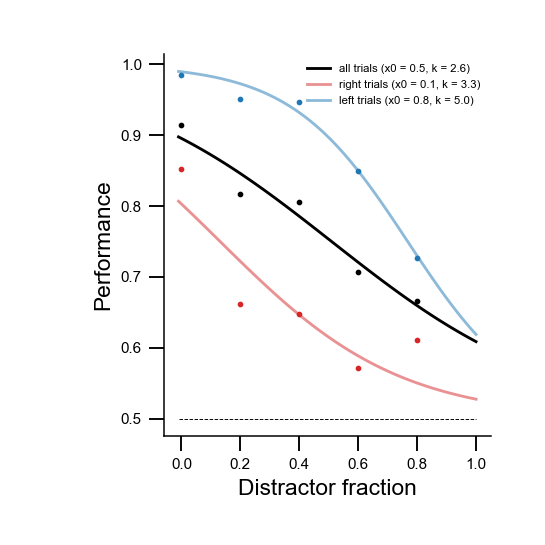

In [98]:
import numpy as np

target_position = np.array(trialdata.target_choice)
target_position[target_position == 1] = -1
target_position[target_position == 2] = 1
distractor_frac = (1-(np.array(trialdata.target_rate - trialdata.distractor_rate)/np.array(trialdata.target_rate)))
unique_distractors = np.unique(distractor_frac)
rewarded = np.array(trialdata.rewarded)
rewarded_right = np.array((trialdata.rewarded) & (target_position == -1))

target_position = trialdata.target_choice
performance = []
trial_idx = []
rperformance = []
rtrial_idx = []
lperformance = []
ltrial_idx = []
for u in unique_distractors:
    idx = np.where((distractor_frac == u) & np.array(trialdata.initiated))[0]
    performance.append(np.sum(rewarded[idx])/len(idx))
    trial_idx.append(idx)
    lidx = np.where((target_position == 1) & (distractor_frac == u) & np.array(trialdata.initiated))[0]
    lperformance.append(np.sum(rewarded[lidx])/len(lidx))
    ltrial_idx.append(lidx)

    ridx = np.where((target_position == 2) & (distractor_frac == u) & np.array(trialdata.initiated))[0]
    rperformance.append(np.sum(rewarded[ridx])/len(ridx))
    rtrial_idx.append(ridx)

%matplotlib notebook
import pylab as plt

from scipy.optimize import curve_fit

def sigmoid(x, x0, k):
    y =  0.5 + 0.5 / (1+np.exp(k*(x-x0)))
    return y
performancefit, pcov = curve_fit(sigmoid, unique_distractors, performance)
lperformancefit, pcov = curve_fit(sigmoid, unique_distractors, lperformance)
rperformancefit, pcov = curve_fit(sigmoid, unique_distractors, rperformance)

x = np.linspace(-.01,1,100)

fig = plt.figure(figsize=[4,4])
fig.add_axes([.3,.2,.6,.7])
plt.plot(x,sigmoid(x,*performancefit),'k',label='all trials (x0 = {0:1.1f}, k = {1:1.1f})'.format(*performancefit))
plt.plot(unique_distractors,performance,'.k')
plt.plot(unique_distractors,rperformance,'.',color = colors[1])
plt.plot(x,sigmoid(x,*rperformancefit),color=colors[1],label='right trials (x0 = {0:1.1f}, k = {1:1.1f})'.format(*rperformancefit),
         alpha = 0.5)
plt.plot(unique_distractors,lperformance,'.r',color = colors[2])
plt.plot(x,sigmoid(x,*lperformancefit),label='left trials (x0 = {0:1.1f}, k = {1:1.1f})'.format(*lperformancefit),
         color = colors[2],alpha = 0.5)
plt.plot(x,x*0+0.5,'k--',lw=0.5)
plt.legend(fontsize=6,frameon=False)
plt.xlabel('Distractor fraction')
plt.ylabel('Performance')
plt.savefig('performance.pdf')
# shuffled chance np.random.seed(128)


In [97]:
# trial averages
ravg = []
lavg = []
rstackavg = []
lstackavg = []
period = 'PlayStimulus'
frate = np.diff(camtime[:2])
frate = 1./np.diff(camtime[-2:])
npre = int(1*frate)
npost = int(3*frate)
for idistract in tqdm(range(len(ltrial_idx))):
    ts = []
    for t in ltrial_idx[idistract]:
        if trialdata.iloc[t].rewarded:
            ts.append(sync.iloc[np.where(sync['count'] == t)[-1][-1]].timestamp/1000.)
            ts[-1] = ts[-1]+trialdata.iloc[t][period][0]
    
    frameidx = [np.where(camtime<=t)[0][-1] for t in ts]
    
    ltrialframes0 = [stack.SVT[:,f-npre:npost+f] for f in frameidx]
    lavg.append(np.stack(ltrialframes0).mean(axis=0))

    ts = []
    for t in rtrial_idx[0]:
        if trialdata.iloc[t].rewarded:
            ts.append(sync.iloc[np.where(sync['count'] == t)[-1][-1]].timestamp/1000.)
            ts[-1] = ts[-1]+trialdata.iloc[t][period][0]
    
    frameidx = [np.where(camtime<=t)[0][-1] for t in ts]
    rtrialframes0 = [stack.SVT[:,f-npre:npost+f] for f in frameidx]
    ravg.append(np.stack(rtrialframes0).mean(axis=0))
    rstackavg.append(reconstruct(stack.U_warped,ravg[-1]))
    lstackavg.append(reconstruct(stack.U_warped,lavg[-1]))

100%|██████████| 5/5 [01:06<00:00, 13.38s/it]


In [4]:
%matplotlib notebook

<IPython.core.display.Javascript object>


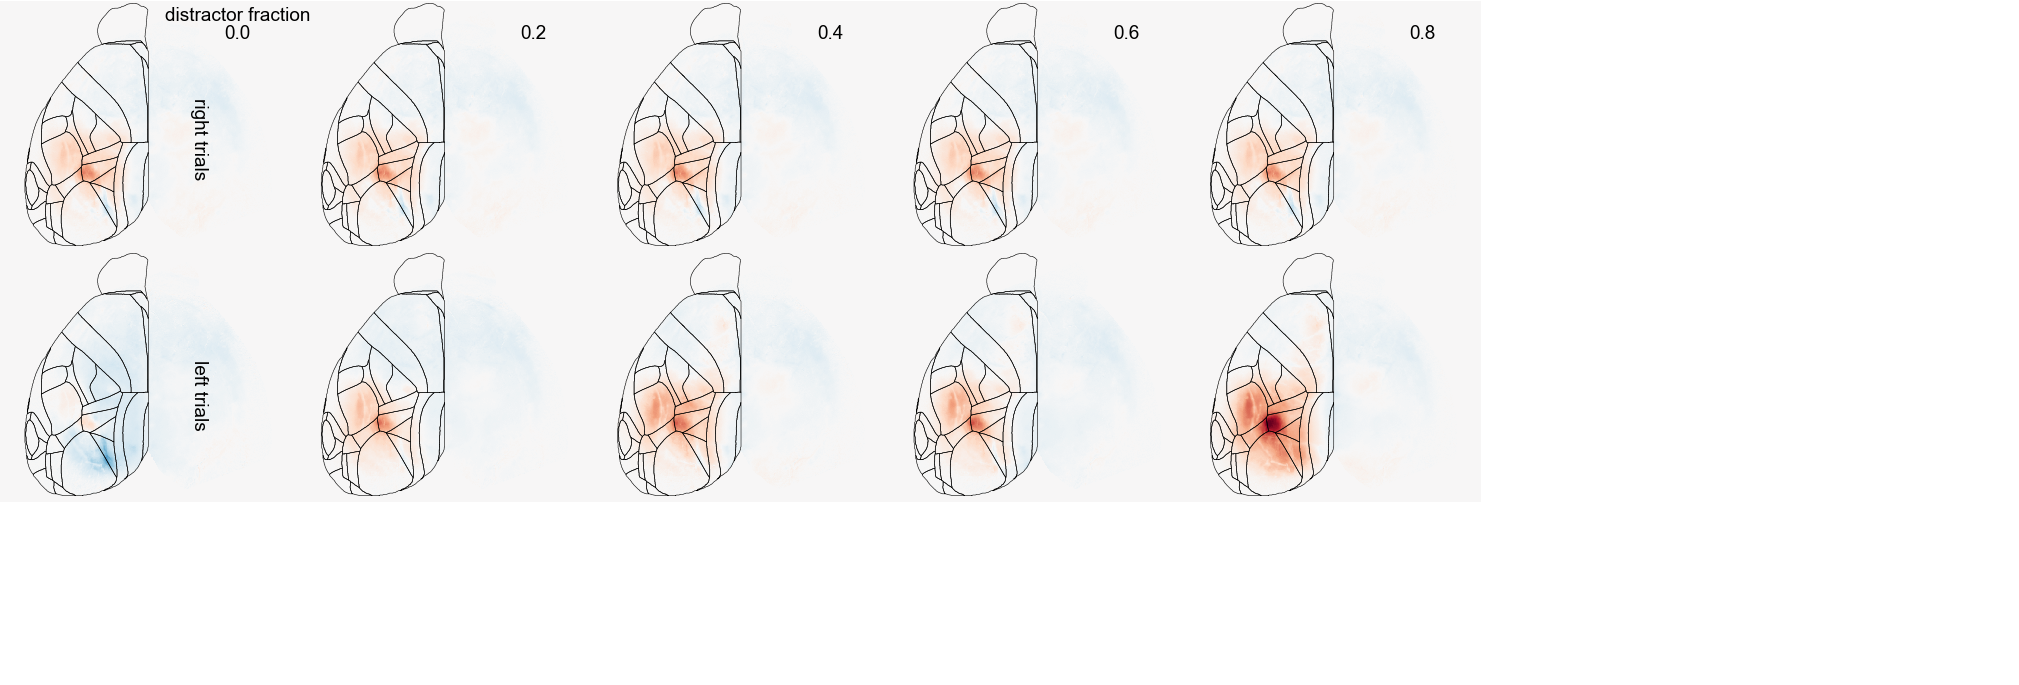

Saving movie : 61it [00:07,  8.16it/s]                        

Saved to avg_allconditions.avi


In [99]:
def plot_aid(fname=None):
    dat = []
    for ii in np.arange(len(rstackavg)):
        xoff = rstackavg[ii].shape[2]*(ii)
        for i,r in nref_regions.iterrows():
            plt.plot(xoff+r['left_x'],r['left_y'],color='k',lw=0.3)
            plt.plot(xoff+r['left_x'],np.array(r['left_y'])+rstackavg[ii].shape[1],color='k',lw=0.3)
        if ii == 0:
            plt.text(xoff+rstackavg[ii].shape[2]*0.8,50,'distractor fraction',ha='center',va = 'bottom')    
        plt.text(xoff+rstackavg[ii].shape[2]*0.8,50,'{0:1.1f}'.format(unique_distractors[ii]),ha='center',va = 'top')
        if ii == len(rstackavg)-1:
            plt.text(410,rstackavg[ii].shape[1]*.7,'right trials', rotation=-90)
            plt.text(410,rstackavg[ii].shape[1]*.7 + rstackavg[ii].shape[1],'left trials', rotation=-90)
        tmp = np.concatenate([rstackavg[ii]-np.mean(rstackavg[ii][:npre],axis=0),
                                      lstackavg[ii]-np.mean(lstackavg[ii][:npre],axis=0)],axis=1)
        if len(dat)==0:
            dat = tmp.copy()
        else:
            dat = np.concatenate([dat,tmp.copy()],axis=2)
    tmp[npre:npre+30,:30,:30] = 1
    plt.axis('off')
    if fname is None:
        nb_play_movie(dat,
                      clim=[-0.03,0.03],cmap='RdBu_r')
    else:
        nb_save_movie(dat,filename=fname,
                      clim=[-0.03,0.03],cmap='RdBu_r')
fig=plt.figure(figsize=[10.88,  3.71])
fig.add_axes([0,0,1,1])
# plot_aid()
plot_aid('avg_allconditions.avi')

<IPython.core.display.Javascript object>


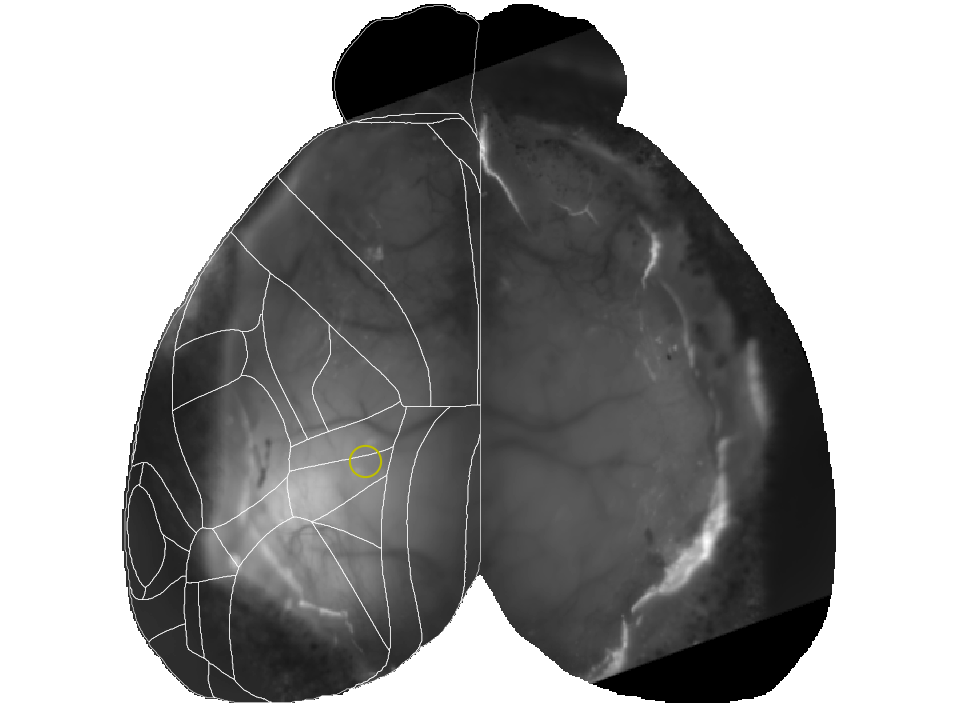

In [3]:
# Plot the injection site in allen coords
#load avg
avg = np.load('JC018_SpatialSparrow_20201231_120211/frames_average.npy')
m = [im_apply_transform(a,M = lmarks['transform'])/np.max(a) for a in avg]
nm = np.zeros([*m[0].shape,3])
for i in range(len(m)):
    m[i][~mask] = np.nan
nm[:,:,2] = m[1]
nm[:,:,1] = m[0]/2

fig = plt.figure()
fig.add_axes([0,0,1,1])
for i,r in nref_regions.iterrows():
    plt.plot(r['left_x'],r['left_y'],color='w',lw=0.3)
plt.imshow(m[0],cmap='gray')
plt.axis('off')
plt.plot(233,345,'yo',markersize = 15, markerfacecolor = 'none')
plt.savefig('injection_site.pdf')

In [94]:
# 31 is area A
# 27 is area PM
mm = (atlas[:,:] == 27)
area_a = stack.get_timecourse(np.where(mm))
zed_area_a = np.mean(area_a,axis=0)#(np.mean(area_a,axis=0) - np.std(area_a,axis=0))/ np.std(area_a,axis=0)

ravg = []
lavg = []
rstackavg = []
lstackavg = []
period = 'PlayStimulus'
frate = np.diff(camtime[:2])
frate = 1./np.diff(camtime[-2:])
npre = int(1*frate)
npost = int(3*frate)
for idistract in tqdm(range(len(ltrial_idx))):
    ts = []
    for t in ltrial_idx[idistract]:
        if trialdata.iloc[t].rewarded:
            ts.append(sync.iloc[np.where(sync['count'] == t)[-1][-1]].timestamp/1000.)
            ts[-1] = ts[-1]+trialdata.iloc[t][period][0]
    
    frameidx = [np.where(camtime<=t)[0][-1] for t in ts]
    lavg.append(np.stack([zed_area_a[f-npre:npost+f] for f in frameidx]))
    ts = []
    for t in rtrial_idx[idistract]:
        if trialdata.iloc[t].rewarded:
            ts.append(sync.iloc[np.where(sync['count'] == t)[-1][-1]].timestamp/1000.)
            ts[-1] = ts[-1]+trialdata.iloc[t][period][0]
    
    frameidx = [np.where(camtime<=t)[0][-1] for t in ts]
    
    ravg.append(np.stack([zed_area_a[f-npre:npost+f] for f in frameidx]))



100%|██████████| 5/5 [00:00<00:00, 16.66it/s]


<IPython.core.display.Javascript object>


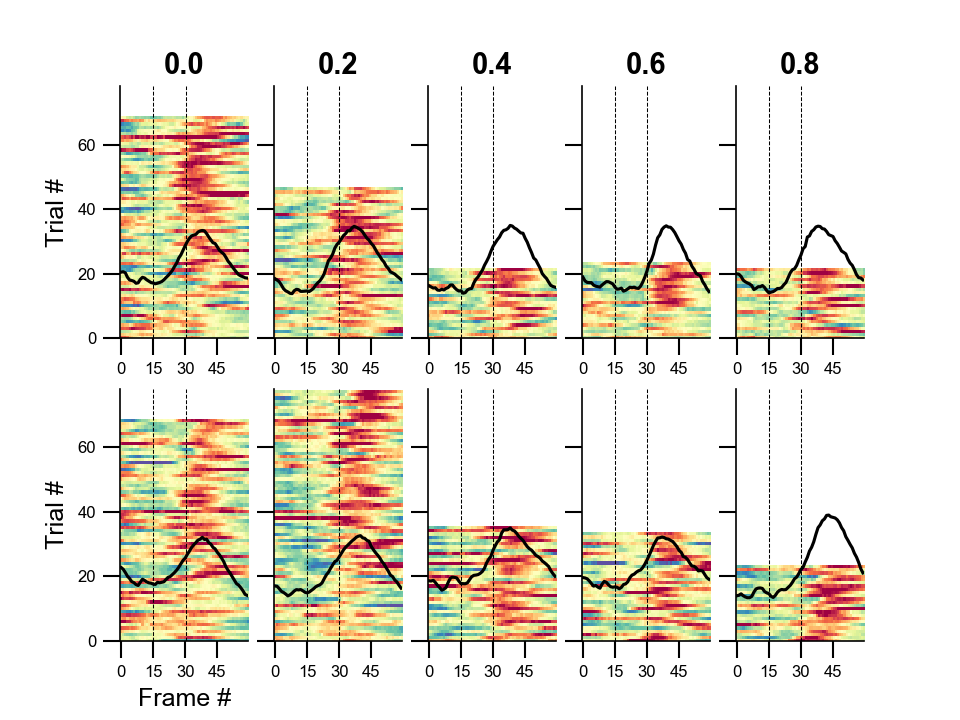

In [95]:
fig = plt.figure()
maxtrials = np.max([np.max([len(r),len(l)]) for l,r in zip(lavg,ravg)])

for idist in range(len(unique_distractors)):
    fig.add_subplot(2,len(unique_distractors),(idist)+1)
    plt.imshow(ravg[idist][:,:],clim = [-0.05,0.05],cmap='Spectral_r',aspect = 'auto',origin='bottom')
    plt.plot(np.mean(ravg[idist][:,:],axis=0)*600+20)
    plt.plot([npre,npre],[0,maxtrials],'k--',lw=0.5)
    plt.plot(([npre,npre])+frate,[0,maxtrials],'k--',lw=0.5)
    plt.ylim([0,maxtrials])
    plt.title('{0:1.1f}'.format(unique_distractors[idist]))
    plt.xticks([0,15,30,45])
    if idist == 0:
        plt.ylabel('Trial #')
    if idist != 0:
        plt.yticks([0,20,40,60],['','','',''])
    fig.add_subplot(2,len(unique_distractors),len(unique_distractors)+(idist)+1)
    plt.imshow(lavg[idist][:,:],clim = [-0.05,0.05],cmap='Spectral_r',aspect = 'auto',origin='bottom')
    plt.ylim([0,maxtrials])
    plt.plot(np.mean(lavg[idist][:,:],axis=0)*600+20)
    plt.plot([npre,npre],[0,maxtrials],'k--',lw=0.5)
    plt.plot(([npre,npre])+frate,[0,maxtrials],'k--',lw=0.5)
    if idist != 0:
        plt.yticks([0,20,40,60],['','','',''])
    plt.xticks([0,15,30,45])
    if idist == 0:
        plt.ylabel('Trial #')
        plt.xlabel('Frame #')
plt.savefig('area_pm_trialresponses.pdf')

In [93]:
areanames

[[1, 'MOB_left'],
 [-1, 'MOB_right'],
 [2, 'FRP_left'],
 [-2, 'FRP_right'],
 [3, 'MOp_left'],
 [-3, 'MOp_right'],
 [4, 'MOs_left'],
 [-4, 'MOs_right'],
 [5, 'SSp-n_left'],
 [-5, 'SSp-n_right'],
 [6, 'SSp-m_left'],
 [-6, 'SSp-m_right'],
 [7, 'SSp-un_left'],
 [-7, 'SSp-un_right'],
 [8, 'PL_left'],
 [-8, 'PL_right'],
 [9, 'ACAd_left'],
 [-9, 'ACAd_right'],
 [10, 'RSPv_left'],
 [-10, 'RSPv_right'],
 [11, 'RSPd_left'],
 [-11, 'RSPd_right'],
 [12, 'RSPagl_left'],
 [-12, 'RSPagl_right'],
 [13, 'VISC_left'],
 [-13, 'VISC_right'],
 [14, 'SSs_left'],
 [-14, 'SSs_right'],
 [15, 'SSp-bfd_left'],
 [-15, 'SSp-bfd_right'],
 [16, 'SSp-tr_left'],
 [-16, 'SSp-tr_right'],
 [17, 'SSp-ll_left'],
 [-17, 'SSp-ll_right'],
 [18, 'SSp-ul_left'],
 [-18, 'SSp-ul_right'],
 [19, 'TEa_left'],
 [-19, 'TEa_right'],
 [20, 'AUDd_left'],
 [-20, 'AUDd_right'],
 [21, 'AUDp_left'],
 [-21, 'AUDp_right'],
 [22, 'AUDpo_left'],
 [-22, 'AUDpo_right'],
 [23, 'AUDv_left'],
 [-23, 'AUDv_right'],
 [24, 'VISli_left'],
 [-24, 'VISli_r